In [1]:
pip install transformers torch numpy gudhi -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
text = ["Quantum information theory is a vast field that delves into the mechanics of information in the quantum realm, using principles of quantum physics to redefine our understanding of information processing. However, what we currently comprehend about quantum information theory is just the tip of the iceberg. As we venture deeper into this realm, we are likely to encounter new phenomena, such as quantum entanglement and superposition, that are far removed from our classical understanding of information transmission. Quantum computers, for instance, promise an information processing revolution, but their full potential and the underlying complexities of quantum states and their manipulation remain elusive. As researchers continue to explore these quantum depths, we can expect quantum information theory to provide transformative impacts across numerous fields, from cryptography to machine learning."]

In [3]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel


def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
    model = AutoModel.from_pretrained("xlm-roberta-large") 


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 181, 64])
tensor([[[ 0.0163, -0.0173, -0.0057,  ..., -0.0273,  0.0024,  0.0038],
         [ 0.0134, -0.0065, -0.0065,  ..., -0.0135, -0.0159,  0.0353],
         [ 0.0106, -0.0208, -0.0089,  ..., -0.0369, -0.0059,  0.0318],
         ...,
         [ 0.0192, -0.0105, -0.0012,  ..., -0.0018,  0.0002,  0.0090],
         [ 0.0502, -0.0490, -0.0101,  ..., -0.0142,  0.0052,  0.0215],
         [-0.0197, -0.0132,  0.0331,  ...,  0.0172, -0.0310,  0.0259]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


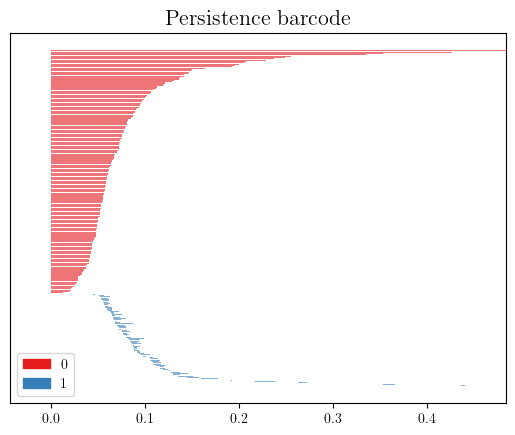

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [5]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizerFast

def cluster_and_get_words(context, sentence, eps=0.05):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_words(output, text[i]))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(words)}")

Clusters for text 0:
Cluster 0: ▁Quant, ▁to, ▁Quant, ▁for, ▁to
Cluster 1: ▁information, ▁information, ▁information
Cluster 2: ▁theory, ▁theory, ▁theory
Cluster 3: ▁into, ▁the, ▁the, ▁real, sic, ▁process, ▁what, ▁we, ▁currently, ▁the, ▁of, ▁the, ▁we, ▁into, ▁real, ▁to, ▁ph, tang, ▁super, ▁from, ▁process, ▁revolution, ▁potential, ▁under, ▁research, ▁to, depth, ▁can, ▁to, ▁transforma, tive, ▁impact, crypt
Cluster 4: ▁princip, ▁manipula
Cluster 5: ▁quantum, ▁quantum, ▁quantum, ▁quantum, ▁quantum
Cluster 6: phy, ly
Cluster 7: ▁understanding, ▁understanding, ▁learning
Cluster 8: ▁just, ▁likely
Cluster 9: ▁, ▁
Cluster 10: ▁this, ▁their
Cluster 11: ▁we, ▁that, ▁we
Cluster 12: ▁classic, ▁complex
Cluster 13: ▁information, ▁information
Cluster 14: s, s


Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.21072255 0.22480069 0.09797088 0.16032087 0.08374479
  0.184872  ]
 [0.21072255 0.         0.37292684 0.17132846 0.06594862 0.23223042
  0.06109672]
 [0.22480069 0.37292684 0.         0.25874237 0.33411137 0.18599958
  0.36963997]
 [0.09797088 0.17132846 0.25874237 0.         0.11677755 0.10955201
  0.15866308]
 [0.16032087 0.06594862 0.33411137 0.11677755 0.         0.17804037
  0.06384728]
 [0.08374479 0.23223042 0.18599958 0.10955201 0.17804037 0.
  0.21878436]
 [0.184872   0.06109672 0.36963997 0.15866308 0.06384728 0.21878436
  0.        ]]


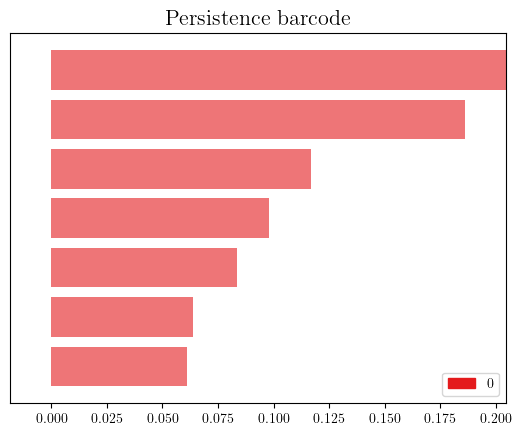

[(0, (0.0, inf)),
 (0, (0.0, 0.18599958331220276)),
 (0, (0.0, 0.11677755236070866)),
 (0, (0.0, 0.09797088350042026)),
 (0, (0.0, 0.0837447875514504)),
 (0, (0.0, 0.06384728187412174)),
 (0, (0.0, 0.06109672421986496))]

In [6]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    print(f'Distance matrix: {distances.shape}')
    print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
compute_phrase_distances_and_homology(context[0], text[0], "the tip of the iceberg")

In [7]:
text_2 = ["Language morphology, the study of the internal structure of words, is an equally captivating field. The languages we speak today, with their intricate rules and exceptions, are merely the tip of the iceberg. Underneath the surface of everyday conversation lie complex systems of morphemes - the smallest units of meaning - that combine to form words and express nuanced concepts. Inflectional morphemes modify a word's tense, number, or case, while derivational morphemes can change a word's meaning or part of speech entirely. This intricate structure is hidden beneath the surface of spoken and written language, often unnoticed by casual speakers. As linguists continue to delve into the depths of language morphology, they uncover fascinating patterns and structures that deepen our understanding of human communication."]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.224008   0.23669394 0.17462518 0.19667015 0.0772139
  0.17933485]
 [0.224008   0.         0.38373601 0.17800182 0.05677928 0.27709651
  0.081989  ]
 [0.23669394 0.38373601 0.         0.26961898 0.35547246 0.20422324
  0.3665617 ]
 [0.17462518 0.17800182 0.26961898 0.         0.13436178 0.22373279
  0.16842708]
 [0.19667015 0.05677928 0.35547246 0.13436178 0.         0.25385115
  0.07544997]
 [0.0772139  0.27709651 0.20422324 0.22373279 0.25385115 0.
  0.23441038]
 [0.17933485 0.081989   0.3665617  0.16842708 0.07544997 0.23441038
  0.        ]]


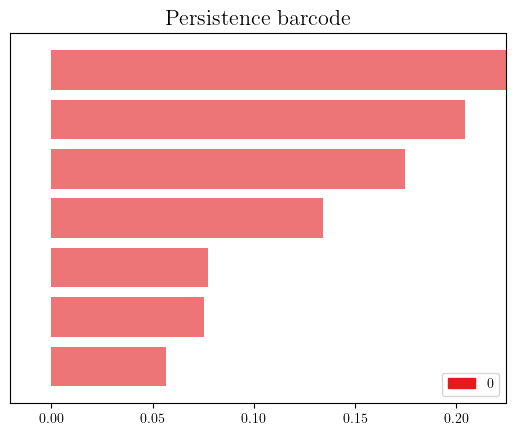

[(0, (0.0, inf)),
 (0, (0.0, 0.2042232393475107)),
 (0, (0.0, 0.17462518313902334)),
 (0, (0.0, 0.13436178134920046)),
 (0, (0.0, 0.0772139017364859)),
 (0, (0.0, 0.07544997427197231)),
 (0, (0.0, 0.05677927940933225))]

In [8]:
context_2 = [compute_output(t, layer, head) for t in text_2]
compute_phrase_distances_and_homology(context_2[0], text_2[0], "the tip of the iceberg")

---

## English Persistent Homology Comparison

Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.21072255 0.22480069 0.09797088 0.16032087 0.08374479
  0.184872  ]
 [0.21072255 0.         0.37292684 0.17132846 0.06594862 0.23223042
  0.06109672]
 [0.22480069 0.37292684 0.         0.25874237 0.33411137 0.18599958
  0.36963997]
 [0.09797088 0.17132846 0.25874237 0.         0.11677755 0.10955201
  0.15866308]
 [0.16032087 0.06594862 0.33411137 0.11677755 0.         0.17804037
  0.06384728]
 [0.08374479 0.23223042 0.18599958 0.10955201 0.17804037 0.
  0.21878436]
 [0.184872   0.06109672 0.36963997 0.15866308 0.06384728 0.21878436
  0.        ]]


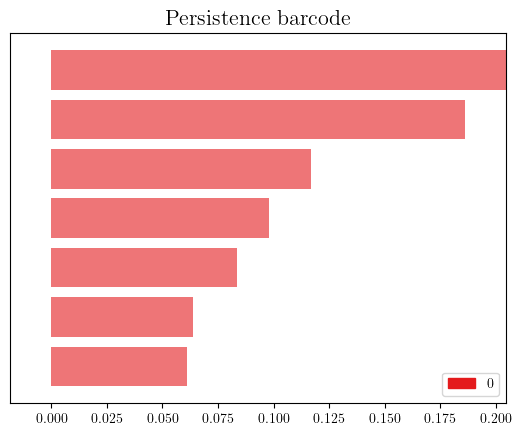

Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.224008   0.23669394 0.17462518 0.19667015 0.0772139
  0.17933485]
 [0.224008   0.         0.38373601 0.17800182 0.05677928 0.27709651
  0.081989  ]
 [0.23669394 0.38373601 0.         0.26961898 0.35547246 0.20422324
  0.3665617 ]
 [0.17462518 0.17800182 0.26961898 0.         0.13436178 0.22373279
  0.16842708]
 [0.19667015 0.05677928 0.35547246 0.13436178 0.         0.25385115
  0.07544997]
 [0.0772139  0.27709651 0.20422324 0.22373279 0.25385115 0.
  0.23441038]
 [0.17933485 0.081989   0.3665617  0.16842708 0.07544997 0.23441038
  0.        ]]


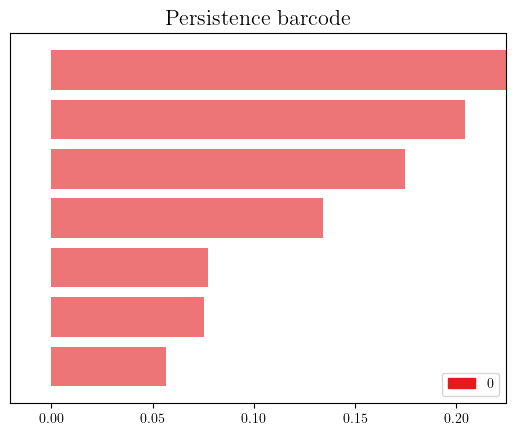

Bottleneck distance: 0.057847630778314674
Wasserstein distance: = 0.13


In [9]:
# from gudhi.wasserstein import wasserstein_distance 
# Could also be: 
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "the tip of the iceberg")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "the tip of the iceberg")

dimension = 0 # Choose homology dimension
# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf') and pt[0] == dimension])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf') and pt[0] == dimension])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Yiddish Persistent Homology Comparison

In [10]:
text_3 = ["קוואַנטום אינפֿאָרמאַציע טעאָריע איז אַ וואַסט פעלד וואָס דעלוווז אין די מאַקאַניקס פון אינפֿאָרמאַציע אין די קוואַנטום מעלוכע, ניצן פּרינסאַפּאַלז פון קוואַנטום פיזיק צו רידיפיין אונדזער פארשטאנד פון אינפֿאָרמאַציע פּראַסעסינג. אָבער, וואָס מיר איצט באַגרייַפן וועגן קוואַנטום אינפֿאָרמאַציע טעאָריע איז נאָר דער שפּיץ פון די ייסבערג. ווען מיר פירנעם דיפּער אין דעם מעלוכע, מיר זענען מסתּמא צו טרעפן נייַע דערשיינונגען, אַזאַ ווי קוואַנטום ענטאַנגגאַלמאַנט און סופּערפּאָסיטיאָן, וואָס זענען ווייַט אַוועק פון אונדזער קלאַסיש פארשטאנד פון אינפֿאָרמאַציע טראַנסמיסיע. קוואַנטום קאָמפּיוטערס, פֿאַר בייַשפּיל, צוזאָג אַן אינפֿאָרמאַציע פּראַסעסינג רעוואָלוציע, אָבער זייער פול פּאָטענציעל און די אַנדערלייינג קאַמפּלעקסיטיז פון קוואַנטום שטאַטן און זייער מאַניפּיאַליישאַן בלייבן ילוסיוו. ווי ריסערטשערז פאָרזעצן צו ויספאָרשן די קוואַנטום טיפענישן, מיר קענען דערוואַרטן קוואַנטום אינפֿאָרמאַציע טעאָריע צו צושטעלן טראַנספאָרמאַטיוו ימפּאַקץ אין פילע פעלדער, פֿון קריפּטאָגראַפי צו מאַשין לערנען."]

text_4 = ["שפּראַך מאָרפאָלאָגי, די לערנען פון די ינערלעך סטרוקטור פון ווערטער, איז אַן גלייַך קאַפּטיווייטינג פעלד. די שפראכן, וואס מיר רעדן היינט, מיט זייערע איינגעפלאנצטע כללים און אויסנאמען, זענען בלויז דער שפּיץ פון די ייסבערג. אונטער די ייבערפלאַך פון וואָכעדיק שמועס ליגן קאָמפּלעקס סיסטעמען פון מאָרפעמעס - די קלענסטער באַטייַט וניץ - וואָס פאַרבינדן צו פאָרעם ווערטער און אויסדריקן נואַנסט קאַנסעפּס. ינפלעקטיאָנאַל מאָרפעמעס מאָדיפיצירן אַ וואָרט ס געשפּאַנט, נומער, אָדער פאַל, בשעת דעריוואַטיוו מאָרפעמעס קענען טוישן אַ וואָרט ס טייַטש אָדער טייל פון רייד לעגאַמרע. דעם ינטראַקאַט סטרוקטור איז פאַרבאָרגן אונטער די ייבערפלאַך פון גערעדט און געשריבן שפּראַך, אָפט אַננאָוטיסט דורך גלייַכגילטיק ספּיקערז. ווי לינגוויסטן פאָרזעצן צו דעוועלירן אין די טיפענישן פון שפּראַך מאָרפאָלאָגי, זיי ופדעקן פאַסאַנייטינג פּאַטערנז און סטראַקטשערז וואָס דיפּער אונדזער פארשטאנד פון מענטש קאָמוניקאַציע."]

In [11]:
context_3 = [compute_output(t, layer, head) for t in text_3]

context_4 = [compute_output(t, layer, head) for t in text_4]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁דער', '▁שפּ', 'יץ', '▁פון', '▁די', '▁', 'ייס', 'בער', 'ג']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.25689826 0.30471323 1.45175167 0.27138097 0.26587415
  0.36232254 0.73688436 0.3716493 ]
 [0.25689826 0.         0.08534856 1.56945331 0.07382845 0.27416495
  0.21719266 0.82106776 0.13440408]
 [0.30471323 0.08534856 0.         1.60881305 0.11061382 0.32387174
  0.16569173 0.85178788 0.11684687]
 [1.45175167 1.56945331 1.60881305 0.         1.56931179 1.30326238
  1.67038841 0.92522207 1.61961318]
 [0.27138097 0.07382845 0.11061382 1.56931179 0.         0.27483461
  0.24312303 0.84384883 0.12851612]
 [0.26587415 0.27416495 0.32387174 1.30326238 0.27483461 0.
  0.42075091 0.60514043 0.33504049]
 [0.36232254 0.21719266 0.16569173 1.67038841 0.24312303 0.42075091
  0.         0.88389086 0.2149313 ]
 [0.73688436 0.82106776 0.85178788 0.92522207 0.84384883 0.60514043
  0.88389086 0.         0.8696615 ]
 [0.3716493  0.13440408 0.11684687 1.619613

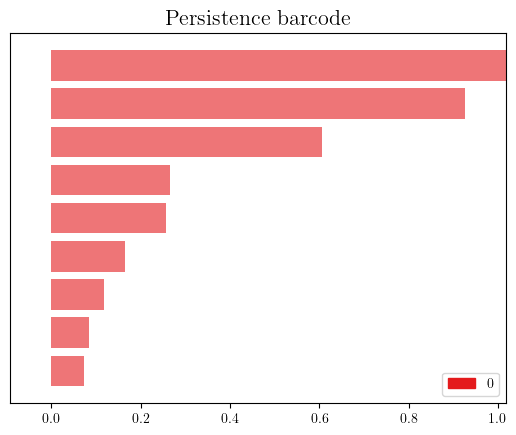

Tokens of the sub-collection: ['▁דער', '▁שפּ', 'יץ', '▁פון', '▁די', '▁', 'ייס', 'בער', 'ג']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.26069779 0.42927278 1.48424731 0.29604071 0.36729316
  0.21002472 0.71612986 0.34104363]
 [0.26069779 0.         0.23368427 1.53258028 0.13094617 0.33242334
  0.28600595 0.73835167 0.14927462]
 [0.42927278 0.23368427 0.         1.68548921 0.17722124 0.46952295
  0.37431671 0.89644983 0.20409858]
 [1.48424731 1.53258028 1.68548921 0.         1.55736232 1.23090499
  1.58673687 0.90086988 1.50540627]
 [0.29604071 0.13094617 0.17722124 1.55736232 0.         0.33524027
  0.30484699 0.78014194 0.13064103]
 [0.36729316 0.33242334 0.46952295 1.23090499 0.33524027 0.
  0.4498488  0.49170175 0.28805904]
 [0.21002472 0.28600595 0.37431671 1.58673687 0.30484699 0.4498488
  0.         0.78402041 0.34152979]
 [0.71612986 0.73835167 0.89644983 0.90086988 0.78014194 0.49170175
  0.78402041 0.         0.71482579]
 [0.34104363 0.14927462 0.20409858 1.5054062

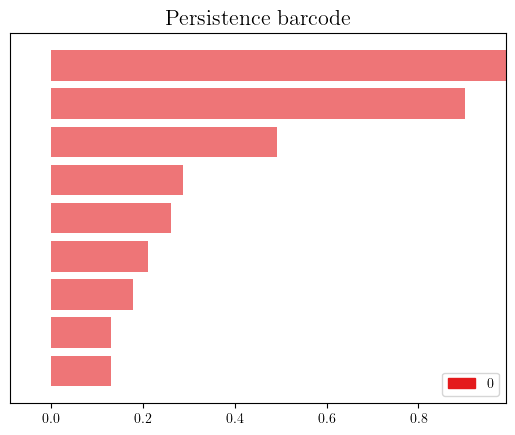

Bottleneck distance: 0.11343867925330997
Wasserstein distance: = 0.37


In [12]:
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "דער שפּיץ פון די ייסבערג")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "דער שפּיץ פון די ייסבערג")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf') and pt[0] == dimension])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf') and pt[0] == dimension])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Hebrew Persistent Homology Comparison



In [13]:
text_5 = ["תורת המידע הקוונטית היא תחום עצום שמתעמק במכניקת המידע בתחום הקוונטים, תוך שימוש בעקרונות הפיזיקה הקוונטית כדי להגדיר מחדש את ההבנה שלנו לגבי עיבוד מידע. עם זאת, מה שאנו מבינים כיום לגבי תורת המידע הקוונטי הוא רק קצה הקרחון. ככל שנעמיק לתוך התחום הזה, אנו צפויים להיתקל בתופעות חדשות, כגון הסתבכות קוונטית וסופרפוזיציה, הרחוקות מההבנה הקלאסית שלנו של העברת מידע. מחשבים קוונטיים, למשל, מבטיחים מהפכת עיבוד מידע, אבל הפוטנציאל המלא שלהם והמורכבות הבסיסית של מצבים קוונטיים והמניפולציה שלהם נותרו חמקמקים. ככל שהחוקרים ממשיכים לחקור את העומקים הקוונטיים הללו, אנו יכולים לצפות שתורת המידע הקוונטית תספק השפעות טרנספורמטיביות על פני תחומים רבים, מקריפטוגרפיה ועד למידת מכונה."]

text_6 = ["מורפולוגיה של השפה, חקר המבנה הפנימי של מילים, היא תחום שובה לב לא פחות. השפות שאנו מדברים היום, עם הכללים והחריגים המורכבים שלהן, הן רק קצה הקרחון. מתחת לפני השטח של השיחה היומיומית מסתתרות מערכות מורכבות של מורפמות - יחידות המשמעות הקטנות ביותר - שמתחברות ליצירת מילים ומבטאות מושגים בניואנסים. מורפמות נטייה משנות את הזמן, המספר או המקרה של מילה, בעוד שמורפמות גזירות יכולות לשנות לחלוטין את המשמעות של מילה או חלק מהדיבור. המבנה המורכב הזה מוסתר מתחת לפני השטח של השפה המדוברת והכתובה, לעתים קרובות מבלי לשים לב לדוברים מזדמנים. בעוד בלשנים ממשיכים להתעמק במעמקי המורפולוגיה של השפה, הם חושפים תבניות ומבנים מרתקים המעמיקים את הבנתנו בתקשורת אנושית."]

In [14]:
context_5 = [compute_output(t, layer, head) for t in text_5]

context_6 = [compute_output(t, layer, head) for t in text_6]


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁ק', 'צה', '▁הקר', 'ח', 'ון']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.17193018 0.20796337 0.15118364 0.48307978]
 [0.17193018 0.         0.10754119 0.07743505 0.37603035]
 [0.20796337 0.10754119 0.         0.10235134 0.38837113]
 [0.15118364 0.07743505 0.10235134 0.         0.39248738]
 [0.48307978 0.37603035 0.38837113 0.39248738 0.        ]]


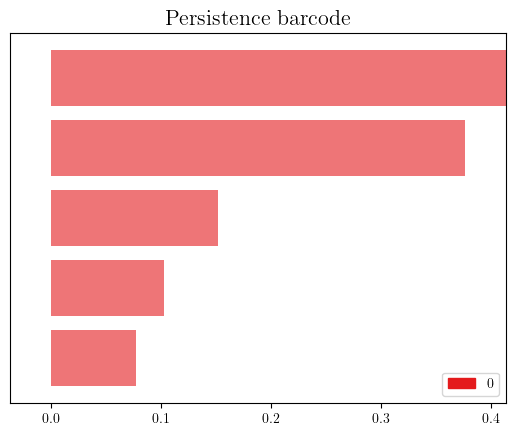

Tokens of the sub-collection: ['▁ק', 'צה', '▁הקר', 'ח', 'ון']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.19446462 0.14945482 0.16390083 0.3704748 ]
 [0.19446462 0.         0.16692143 0.17511597 0.25068237]
 [0.14945482 0.16692143 0.         0.14465048 0.3617755 ]
 [0.16390083 0.17511597 0.14465048 0.         0.35218421]
 [0.3704748  0.25068237 0.3617755  0.35218421 0.        ]]


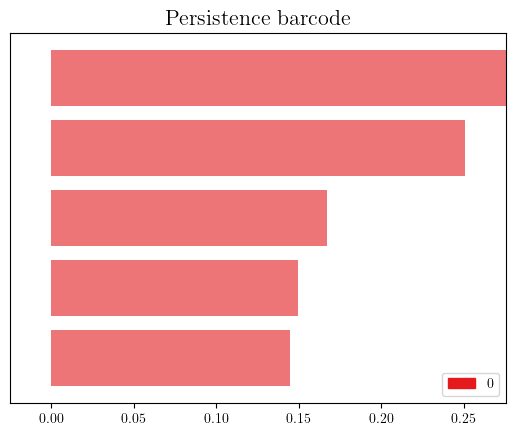

Bottleneck distance: 0.12534797651800428
Wasserstein distance: = 0.26


In [15]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_5[0], text_5[0], "קצה הקרחון")
persistent_homology_2 = compute_phrase_distances_and_homology(context_6[0], text_6[0], "קצה הקרחון")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf') and pt[0] == dimension])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf') and pt[0] == dimension])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Russian Persistent Homology Comparison

In [16]:
text_7 = ["Квантовая теория информации — это обширная область, которая исследует механику информации в квантовой сфере, используя принципы квантовой физики, чтобы пересмотреть наше понимание обработки информации. Однако то, что мы в настоящее время понимаем в квантовой теории информации, — это лишь верхушка айсберга. По мере того, как мы будем углубляться в эту область, мы, вероятно, столкнемся с новыми явлениями, такими как квантовая запутанность и суперпозиция, которые далеки от нашего классического понимания передачи информации. Квантовые компьютеры, например, обещают революцию в обработке информации, но их полный потенциал и основные сложности квантовых состояний и их манипулирования остаются недостижимыми. Поскольку исследователи продолжают исследовать эти квантовые глубины, мы можем ожидать, что квантовая теория информации окажет преобразующее воздействие во многих областях, от криптографии до машинного обучения."]

text_8 = ["Морфология языка, изучение внутренней структуры слов, является столь же увлекательной областью. Языки, на которых мы говорим сегодня, с их запутанными правилами и исключениями — это лишь верхушка айсберга. Под поверхностью повседневного разговора скрываются сложные системы морфем — мельчайших смысловых единиц, — которые объединяются, образуя слова и выражая нюансы понятий. Инфлективные морфемы изменяют время, число или падеж слова, в то время как деривационные морфемы могут полностью изменить значение слова или часть речи. Эта сложная структура скрыта под поверхностью устной и письменной речи, часто незаметная для случайных говорящих. По мере того, как лингвисты продолжают погружаться в глубины языковой морфологии, они открывают захватывающие закономерности и структуры, которые углубляют наше понимание человеческого общения."]

In [17]:
context_7 = [compute_output(t, layer, head) for t in text_7]

context_8 = [compute_output(t, layer, head) for t in text_8]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁верх', 'ушка', '▁ай', 'с', 'берг', 'а']
Distance matrix: (6, 6)
Distance matrix: [[0.         0.06749875 0.67233251 0.35387974 0.06172331 0.13860915]
 [0.06749875 0.         0.68754596 0.37208183 0.06606376 0.10808176]
 [0.67233251 0.68754596 0.         0.35021503 0.70337229 0.73373046]
 [0.35387974 0.37208183 0.35021503 0.         0.37652508 0.43670041]
 [0.06172331 0.06606376 0.70337229 0.37652508 0.         0.13776938]
 [0.13860915 0.10808176 0.73373046 0.43670041 0.13776938 0.        ]]


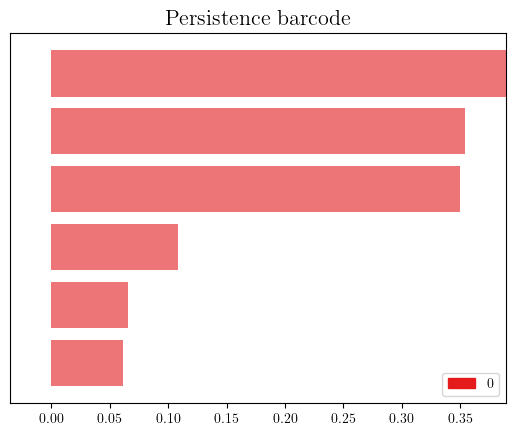

Tokens of the sub-collection: ['▁верх', 'ушка', '▁ай', 'с', 'берг', 'а']
Distance matrix: (6, 6)
Distance matrix: [[0.         0.09275168 0.68666668 0.26576372 0.05418221 0.13998436]
 [0.09275168 0.         0.67130917 0.28847104 0.11888561 0.09485207]
 [0.68666668 0.67130917 0.         0.46517809 0.69747718 0.69778441]
 [0.26576372 0.28847104 0.46517809 0.         0.26814682 0.33637617]
 [0.05418221 0.11888561 0.69747718 0.26814682 0.         0.16708491]
 [0.13998436 0.09485207 0.69778441 0.33637617 0.16708491 0.        ]]


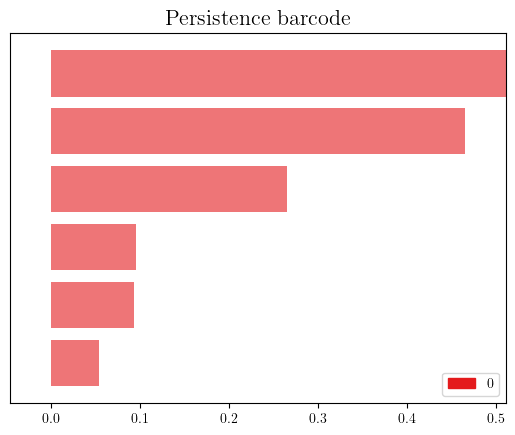

Bottleneck distance: 0.11129834834140923
Wasserstein distance: = 0.24


In [18]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_7[0], text_7[0], "верхушка айсберга")
persistent_homology_2 = compute_phrase_distances_and_homology(context_8[0], text_8[0], "верхушка айсберга")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf') and pt[0] == dimension])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf') and pt[0] == dimension])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## German Persistent Homology Comparison

In [19]:
text_9 = ["Die Quanteninformationstheorie ist ein weites Feld, das sich mit der Informationsmechanik im Quantenbereich befasst und dabei Prinzipien der Quantenphysik nutzt, um unser Verständnis der Informationsverarbeitung neu zu definieren. Allerdings ist das, was wir derzeit über die Quanteninformationstheorie verstehen, nur die Spitze des Eisbergs. Wenn wir tiefer in diesen Bereich vordringen, werden wir wahrscheinlich auf neue Phänomene wie Quantenverschränkung und Superposition stoßen, die weit von unserem klassischen Verständnis der Informationsübertragung entfernt sind. Quantencomputer zum Beispiel versprechen eine Revolution in der Informationsverarbeitung, ihr volles Potenzial und die zugrunde liegende Komplexität von Quantenzuständen und ihrer Manipulation sind jedoch noch nicht bekannt. Während Forscher diese Quantentiefen weiter erforschen, können wir davon ausgehen, dass die Quanteninformationstheorie transformative Auswirkungen auf zahlreiche Bereiche haben wird, von der Kryptographie bis zum maschinellen Lernen."]

text_10 = ["Die Sprachmorphologie, das Studium der inneren Struktur von Wörtern, ist ein ebenso faszinierendes Gebiet. Die Sprachen, die wir heute sprechen, mit ihren komplizierten Regeln und Ausnahmen sind nur die Spitze des Eisbergs. Unter der Oberfläche alltäglicher Gespräche liegen komplexe Systeme von Morphemen – den kleinsten Bedeutungseinheiten – die sich zu Wörtern verbinden und nuancierte Konzepte ausdrücken. Flexionsmorpheme verändern die Zeitform, Numerus oder Kasus eines Wortes, während Ableitungsmorpheme die Bedeutung oder Wortart eines Wortes vollständig verändern können. Diese komplizierte Struktur verbirgt sich unter der Oberfläche der gesprochenen und geschriebenen Sprache und wird von gelegentlichen Sprechern oft unbemerkt. Während Linguisten weiterhin in die Tiefen der Sprachmorphologie vordringen, entdecken sie faszinierende Muster und Strukturen, die unser Verständnis der menschlichen Kommunikation vertiefen."]

In [21]:
context_9 = [compute_output(t, layer, head) for t in text_9]

context_10 = [compute_output(t, layer, head) for t in text_10]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁die', '▁Spitze', '▁des', '▁Eis', 'bergs']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.21414869 0.24032437 0.25544773 0.34828243]
 [0.21414869 0.         0.13479327 0.07279887 0.33569901]
 [0.24032437 0.13479327 0.         0.16153649 0.43712555]
 [0.25544773 0.07279887 0.16153649 0.         0.31473861]
 [0.34828243 0.33569901 0.43712555 0.31473861 0.        ]]


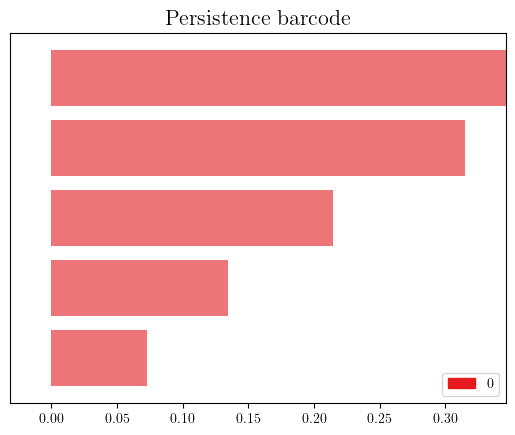

Tokens of the sub-collection: ['▁die', '▁Spitze', '▁des', '▁Eis', 'bergs']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.14522963 0.18242735 0.17928305 0.31382978]
 [0.14522963 0.         0.17759356 0.09169949 0.25600923]
 [0.18242735 0.17759356 0.         0.13517334 0.3941855 ]
 [0.17928305 0.09169949 0.13517334 0.         0.32427422]
 [0.31382978 0.25600923 0.3941855  0.32427422 0.        ]]


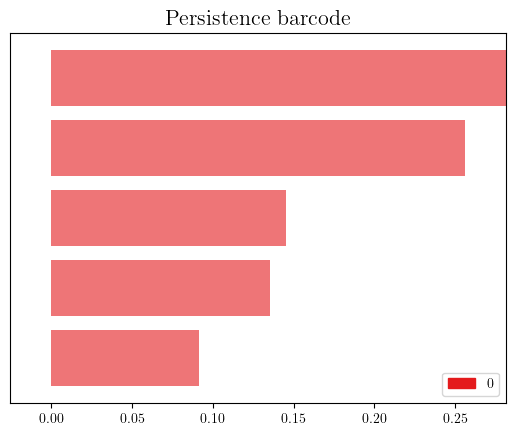

Bottleneck distance: 0.06891906445718926
Wasserstein distance: = 0.15


In [22]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_9[0], text_9[0], "die Spitze des Eisbergs")
persistent_homology_2 = compute_phrase_distances_and_homology(context_10[0], text_10[0], "die Spitze des Eisbergs")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf') and pt[0] == dimension])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf') and pt[0] == dimension])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## French Persistent Homology Comparison

In [23]:
text_11 = ["La théorie de l'information quantique est un vaste domaine qui plonge dans la mécanique de l'information dans le domaine quantique, en utilisant les principes de la physique quantique pour redéfinir notre compréhension du traitement de l'information. Cependant, ce que nous comprenons actuellement sur la théorie de l'information quantique n'est que la pointe de l'iceberg. En nous aventurant plus profondément dans ce domaine, nous sommes susceptibles de rencontrer de nouveaux phénomènes, tels que l'intrication et la superposition quantiques, qui sont très éloignés de notre compréhension classique de la transmission de l'information. Les ordinateurs quantiques, par exemple, promettent une révolution du traitement de l'information, mais leur plein potentiel et les complexités sous-jacentes des états quantiques et de leur manipulation restent insaisissables. Alors que les chercheurs continuent d'explorer ces profondeurs quantiques, nous pouvons nous attendre à ce que la théorie de l'information quantique fournisse des impacts transformateurs dans de nombreux domaines, de la cryptographie à l'apprentissage automatique."]

text_12 = ["La morphologie du langage, l'étude de la structure interne des mots, est un domaine tout aussi captivant. Les langues que nous parlons aujourd'hui, avec leurs règles et exceptions complexes, ne sont que la pointe de l'iceberg. Sous la surface de la conversation quotidienne se trouvent des systèmes complexes de morphèmes - les plus petites unités de sens - qui se combinent pour former des mots et exprimer des concepts nuancés. Les morphèmes flexionnels modifient le temps, le nombre ou la casse d'un mot, tandis que les morphèmes dérivationnels peuvent modifier entièrement le sens ou une partie du discours d'un mot. Cette structure complexe est cachée sous la surface du langage parlé et écrit, souvent inaperçue par les locuteurs occasionnels. Alors que les linguistes continuent à plonger dans les profondeurs de la morphologie du langage, ils découvrent des modèles et des structures fascinants qui approfondissent notre compréhension de la communication humaine."]

In [24]:
context_11 = [compute_output(t, layer, head) for t in text_11]

context_12 = [compute_output(t, layer, head) for t in text_12]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁la', '▁point', 'e', '▁de', '▁l', "'", 'ice', 'berg']
Distance matrix: (8, 8)
Distance matrix: [[0.         0.08901905 0.29157527 0.26558242 0.15120897 0.11165178
  0.1624226  0.10083318]
 [0.08901905 0.         0.22085393 0.30190788 0.21787589 0.18469855
  0.23483861 0.16209841]
 [0.29157527 0.22085393 0.         0.45178237 0.42324667 0.39328345
  0.43661431 0.36400232]
 [0.26558242 0.30190788 0.45178237 0.         0.21770162 0.24499576
  0.22433214 0.22181212]
 [0.15120897 0.21787589 0.42324667 0.21770162 0.         0.07039897
  0.0612592  0.07677249]
 [0.11165178 0.18469855 0.39328345 0.24499576 0.07039897 0.
  0.06517812 0.07395192]
 [0.1624226  0.23483861 0.43661431 0.22433214 0.0612592  0.06517812
  0.         0.10012167]
 [0.10083318 0.16209841 0.36400232 0.22181212 0.07677249 0.07395192
  0.10012167 0.        ]]


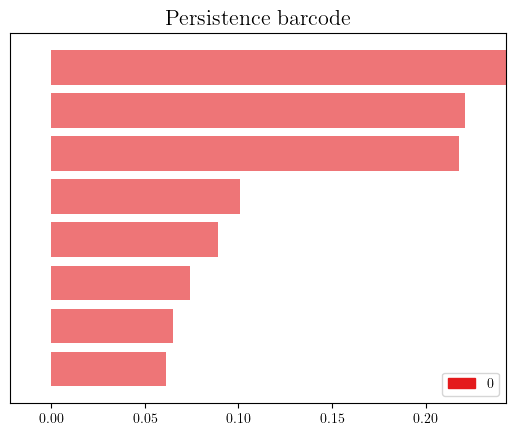

Tokens of the sub-collection: ['▁la', '▁point', 'e', '▁de', '▁l', "'", 'ice', 'berg']
Distance matrix: (8, 8)
Distance matrix: [[0.         0.14359933 0.30939197 0.29746116 0.16037631 0.07077031
  0.14398826 0.09464792]
 [0.14359933 0.         0.19027688 0.36311268 0.26996866 0.19582275
  0.26842367 0.20694909]
 [0.30939197 0.19027688 0.         0.46549897 0.42354834 0.364182
  0.42544621 0.364849  ]
 [0.29746116 0.36311268 0.46549897 0.         0.2283355  0.2914588
  0.25413856 0.25082671]
 [0.16037631 0.26996866 0.42354834 0.2283355  0.         0.12723065
  0.10578387 0.08683339]
 [0.07077031 0.19582275 0.364182   0.2914588  0.12723065 0.
  0.09801377 0.07778322]
 [0.14398826 0.26842367 0.42544621 0.25413856 0.10578387 0.09801377
  0.         0.09717308]
 [0.09464792 0.20694909 0.364849   0.25082671 0.08683339 0.07778322
  0.09717308 0.        ]]


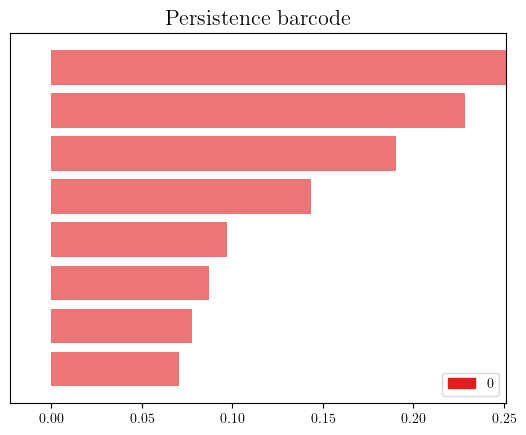

Bottleneck distance: 0.0427661437984332
Wasserstein distance: = 0.12


In [25]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_11[0], text_11[0], "la pointe de l'iceberg")
persistent_homology_2 = compute_phrase_distances_and_homology(context_12[0], text_12[0], "la pointe de l'iceberg")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf') and pt[0] == dimension])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf') and pt[0] == dimension])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")